# PCA + MLDA + KNN

In [1]:
DATASET_FOLDER = "../data/dataset"
TRAINING_DATA_FOLDER = DATASET_FOLDER + "/training_set"
TESTING_DATA_FOLDER = DATASET_FOLDER + "/test_set"
SIGLE_PREDICTION_FOLDER = DATASET_FOLDER + "/single_prediction"

MODEL_FILE = "../models/cnn_model.keras"
LOAD_PRETRAINED_MODEL = True

In [2]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

## 1 - Preprocessing

In [3]:
PRE_RESCALE = 1.0 / 255
PRE_SIZE = (64, 64)
PRE_BATCH_SIZE = 32

In [4]:
def rgb_to_grayscale(img):
    img = tf.image.rgb_to_grayscale(img)
    return img

def max_pool(img):
    # apply max pooling
    img = tf.nn.max_pool(
        img,
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding="SAME",
    )
    return img

def crop_image(img):
    # reshape image to (64, 64, 3)
    img = tf.image.central_crop(img, 0.5)
    tf.reshape(img, [64, 64,3])
    
    return img

def preprocessing_pipeline(img):
    #img = max_pool(img)
    #img = crop_image(img)
    img = rgb_to_grayscale(img)
    return img

train_datagen = ImageDataGenerator(
    rescale=PRE_RESCALE,
    shear_range=0.2,
    zoom_range=1,
    horizontal_flip=True,
    featurewise_center=True,
    preprocessing_function=preprocessing_pipeline,
)

training_set = train_datagen.flow_from_directory(
    TRAINING_DATA_FOLDER,
    target_size=PRE_SIZE,
    batch_size=PRE_BATCH_SIZE,
    class_mode="binary",
)


Found 8000 images belonging to 2 classes.


/Users/guilhermeleonardonunes/temp/reconhecimento_de_padroes_em_estatistica_t2/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


(32, 64, 64, 3)
(32,)
[0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1.]


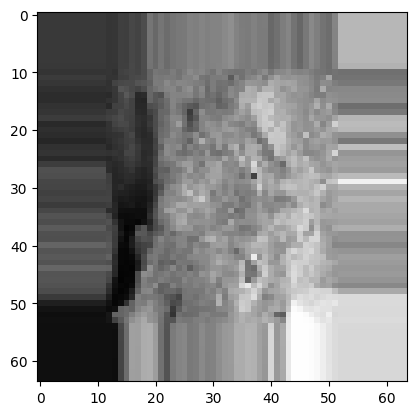

In [5]:
# show one image
import matplotlib.pyplot as plt
import numpy as np

x, y = training_set.next()
print(x.shape)
print(y.shape)
print(y)
plt.imshow(np.squeeze(x[0]))
plt.show()


## 2 - Método

### 2.1 - Cáculo do Vetor Média das Imagens

In [6]:
# get images array from training_set

images_array = []
labels = []
for i in range(len(training_set)):
    x, y = training_set.next()
    images_array.extend(x)
    labels.extend(y)
images_array = np.array(images_array)
# transform images array into 1D array
# resize images array into 2d array

# apply max pooling


images_array = images_array.reshape(
    images_array.shape[0], images_array.shape[1] * images_array.shape[2] * images_array.shape[3]
)
display(images_array.shape)
labels = np.array(labels)
print(images_array.shape)
print(labels.shape)


(8000, 12288)

(8000, 12288)
(8000,)


In [7]:
# calculate average vector of images array
average_vector = np.mean(images_array, axis=0)
print(average_vector.shape)

(12288,)


### 2.2 - Subtração do Vetor Média de Cada Vetor Imagem para Obter o Vetor Média Zero

In [8]:
# subtract average vector from each image vector
zero_mean_images_array = images_array - average_vector
print(zero_mean_images_array.shape)

(8000, 12288)


### 2.3 - Aplicar o PCA nos Vetores Média Zero para extrair a matriz dos componentes principais

In [9]:
# apply PCA to zero mean images array
from sklearn.decomposition import PCA
n_features = 2
pca = PCA(n_components=n_features)
pca.fit(zero_mean_images_array)


PCA(n_components=2)

### 2.4 - Multiplica a matriz dos componentes principais pelo vetor de média zero para obter o vetor reduzido

In [10]:
pca_images_array = np.dot(zero_mean_images_array, pca.components_.T)
print(pca_images_array.shape)

(8000, 2)


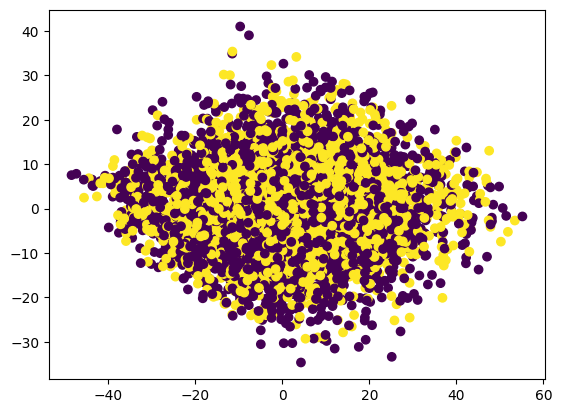

In [11]:
# compare images in the PCA plane
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(pca_images_array[:, 0], pca_images_array[:, 1], c=labels)
plt.show()


## 2.5 - Aplicar o MLDA nos vetores reduzidos

(8000, 1)


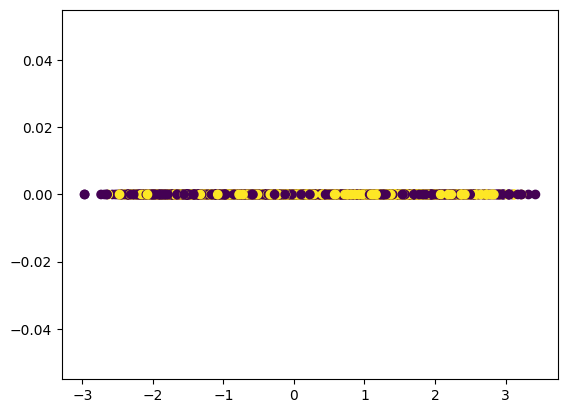

In [14]:
# apply LinearDiscriminantAnalysis to pca_images_array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
n_features = 1 
lda = LinearDiscriminantAnalysis(n_components=n_features)
lda.fit(pca_images_array, labels)
lda_images_array = lda.transform(pca_images_array)
print(lda_images_array.shape)

# compare images in the LDA plane
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(lda_images_array[:, 0], np.zeros(lda_images_array.shape[0]), c=labels)
plt.show()